In [1]:
import numpy as np
import random
import sys

def randPair(s,e):
    return np.random.randint(s,e), np.random.randint(s,e)

class BoardPiece:

    def __init__(self, name, code, pos):
        self.name = name #name of the piece
        self.code = code #an ASCII character to display on the board
        self.pos = pos #2-tuple e.g. (1,4)

class BoardMask:

    def __init__(self, name, mask, code):
        self.name = name
        self.mask = mask
        self.code = code

    def get_positions(self): #returns tuple of arrays
        return np.nonzero(self.mask)

def zip_positions2d(positions): #positions is tuple of two arrays
    x,y = positions
    return list(zip(x,y))

class GridBoard:

    def __init__(self, size=4):
        self.size = size #Board dimensions, e.g. 4 x 4
        self.components = {} #name : board piece
        self.masks = {}

    def addPiece(self, name, code, pos=(0,0)):
        newPiece = BoardPiece(name, code, pos)
        self.components[name] = newPiece

    #basically a set of boundary elements
    def addMask(self, name, mask, code):
        #mask is a 2D-numpy array with 1s where the boundary elements are
        newMask = BoardMask(name, mask, code)
        self.masks[name] = newMask

    def movePiece(self, name, pos):
        move = True
        for _, mask in self.masks.items():
            if pos in zip_positions2d(mask.get_positions()):
                move = False
        if move:
            self.components[name].pos = pos

    def delPiece(self, name):
        del self.components['name']

    def render(self):
        dtype = '<U2'
        displ_board = np.zeros((self.size, self.size), dtype=dtype)
        displ_board[:] = ' '

        for name, piece in self.components.items():
            displ_board[piece.pos] = piece.code

        for name, mask in self.masks.items():
            displ_board[mask.get_positions()] = mask.code

        return displ_board

    def render_np(self):
        num_pieces = len(self.components) + len(self.masks)
        displ_board = np.zeros((num_pieces, self.size, self.size), dtype=np.uint8)
        layer = 0
        for name, piece in self.components.items():
            pos = (layer,) + piece.pos
            displ_board[pos] = 1
            layer += 1

        for name, mask in self.masks.items():
            x,y = self.masks['boundary'].get_positions()
            z = np.repeat(layer,len(x))
            a = (z,x,y)
            displ_board[a] = 1
            layer += 1
        return displ_board

def addTuple(a,b):
    return tuple([sum(x) for x in zip(a,b)])

In [2]:
class Gridworld:

    def __init__(self, size=4, mode='static'):
        if size >= 4:
            self.board = GridBoard(size=size)
        else:
            print("Minimum board size is 4. Initialized to size 4.")
            self.board = GridBoard(size=4)

        #Add pieces, positions will be updated later
        self.board.addPiece('Player','P',(0,0))
        self.board.addPiece('Goal','+',(1,0))
        self.board.addPiece('Pit','-',(2,0))
        self.board.addPiece('Wall','W',(3,0))

        if mode == 'static':
            self.initGridStatic()
        elif mode == 'player':
            self.initGridPlayer()
        else:
            self.initGridRand()

    #Initialize stationary grid, all items are placed deterministically
    def initGridStatic(self):
        #Setup static pieces
        self.board.components['Player'].pos = (0,3) #Row, Column
        self.board.components['Goal'].pos = (0,0)
        self.board.components['Pit'].pos = (0,1)
        self.board.components['Wall'].pos = (1,1)

    #Check if board is initialized appropriately (no overlapping pieces)
    #also remove impossible-to-win boards
    def validateBoard(self):
        valid = True

        player = self.board.components['Player']
        goal = self.board.components['Goal']
        wall = self.board.components['Wall']
        pit = self.board.components['Pit']

        all_positions = [piece for name,piece in self.board.components.items()]
        all_positions = [player.pos, goal.pos, wall.pos, pit.pos]
        if len(all_positions) > len(set(all_positions)):
            return False

        corners = [(0,0),(0,self.board.size), (self.board.size,0), (self.board.size,self.board.size)]
        #if player is in corner, can it move? if goal is in corner, is it blocked?
        if player.pos in corners or goal.pos in corners:
            val_move_pl = [self.validateMove('Player', addpos) for addpos in [(0,1),(1,0),(-1,0),(0,-1)]]
            val_move_go = [self.validateMove('Goal', addpos) for addpos in [(0,1),(1,0),(-1,0),(0,-1)]]
            if 0 not in val_move_pl or 0 not in val_move_go:
                #print(self.display())
                #print("Invalid board. Re-initializing...")
                valid = False

        return valid

    #Initialize player in random location, but keep wall, goal and pit stationary
    def initGridPlayer(self):
        #height x width x depth (number of pieces)
        self.initGridStatic()
        #place player
        self.board.components['Player'].pos = randPair(0,self.board.size)

        if (not self.validateBoard()):
            #print('Invalid grid. Rebuilding..')
            self.initGridPlayer()

    #Initialize grid so that goal, pit, wall, player are all randomly placed
    def initGridRand(self):
        #height x width x depth (number of pieces)
        self.board.components['Player'].pos = randPair(0,self.board.size)
        self.board.components['Goal'].pos = randPair(0,self.board.size)
        self.board.components['Pit'].pos = randPair(0,self.board.size)
        self.board.components['Wall'].pos = randPair(0,self.board.size)

        if (not self.validateBoard()):
            #print('Invalid grid. Rebuilding..')
            self.initGridRand()

    def validateMove(self, piece, addpos=(0,0)):
        outcome = 0 #0 is valid, 1 invalid, 2 lost game
        pit = self.board.components['Pit'].pos
        wall = self.board.components['Wall'].pos
        new_pos = addTuple(self.board.components[piece].pos, addpos)
        if new_pos == wall:
            outcome = 1 #block move, player can't move to wall
        elif max(new_pos) > (self.board.size-1):    #if outside bounds of board
            outcome = 1
        elif min(new_pos) < 0: #if outside bounds
            outcome = 1
        elif new_pos == pit:
            outcome = 2

        return outcome

    def makeMove(self, action):
        #need to determine what object (if any) is in the new grid spot the player is moving to
        #actions in {u,d,l,r}
        def checkMove(addpos):
            if self.validateMove('Player', addpos) in [0,2]:
                new_pos = addTuple(self.board.components['Player'].pos, addpos)
                self.board.movePiece('Player', new_pos)

        if action == 'u': #up
            checkMove((-1,0))
        elif action == 'd': #down
            checkMove((1,0))
        elif action == 'l': #left
            checkMove((0,-1))
        elif action == 'r': #right
            checkMove((0,1))
        else:
            pass

    def reward(self):
        if (self.board.components['Player'].pos == self.board.components['Pit'].pos):
            return -10
        elif (self.board.components['Player'].pos == self.board.components['Goal'].pos):
            return 10
        else:
            return -1

    def display(self):
        return self.board.render()

Lets start from the representation of the gridworld

In [3]:
 game = Gridworld(size=4, mode='random') #C

In [4]:
game.display()

array([[' ', ' ', ' ', ' '],
       [' ', '-', ' ', ' '],
       ['W', ' ', ' ', '+'],
       [' ', ' ', ' ', 'P']], dtype='<U2')

In [5]:
game.makeMove('d')
game.makeMove('d')
game.makeMove('l')
game.display()

array([[' ', ' ', ' ', ' '],
       [' ', '-', ' ', ' '],
       ['W', ' ', ' ', '+'],
       [' ', ' ', 'P', ' ']], dtype='<U2')

In [6]:
game.reward()

-1

In [7]:
game.makeMove('l')
game.makeMove('l')
game.makeMove('d')
game.makeMove('d')
game.makeMove('r')
game.makeMove('r')
game.display()

array([[' ', ' ', ' ', ' '],
       [' ', '-', ' ', ' '],
       ['W', ' ', ' ', '+'],
       [' ', ' ', 'P', ' ']], dtype='<U2')

In [8]:
game.makeMove('u')
game.display()

array([[' ', ' ', ' ', ' '],
       [' ', '-', ' ', ' '],
       ['W', ' ', 'P', '+'],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [9]:
game.reward()

-1

In [10]:
game.board.render_np()

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

# Move to the DQN Algorithm

In [11]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [12]:
import numpy as np
import torch
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

l1 = 64
l2 = 200
l3 = 120
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

In [13]:
from collections import deque
epochs = 5000
losses = []
mem_size = 1000 #A
batch_size = 200 #B
replay = deque(maxlen=mem_size) #C
max_moves = 50 #D

h = 0
w, h = 18, 300000
matrix = [[0 for x in range(w)] for y in range(h)] 

e = 0
e,r= 10, 3000000 
experience = [[0 for x in range(e)] for y in range(r)] 

y = 0
u,y= 7, 3000000 
q_table = [[0 for x in range(u)] for y in range(y)] 
q_counter = 0 

counter = 0
num = 0
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        mov += 1
        qval = model(state1) #E
        qval_ = qval.data.numpy()
        
        matrix[counter][9] = qval_[0][np.argmax(qval_)]
        matrix[counter][10] = qval_[0][0]
        matrix[counter][11] = qval_[0][1]
        matrix[counter][12] = qval_[0][2]
        matrix[counter][13] = qval_[0][3]
        
        for k in range(0,4):
            q_table[q_counter][0] = i
            q_table[q_counter][1] = (str(game.board.components['Player'].pos))
            q_table[q_counter][2] = (str(game.board.components['Pit'].pos))
            q_table[q_counter][3] = (str(game.board.components['Goal'].pos))
            q_table[q_counter][4] = (str(game.board.components['Wall'].pos))
            q_table[q_counter][5] = k
            q_table[q_counter][6] = qval_[0][k]
            q_counter+=1
            
        if (random.random() < epsilon): #F
            matrix[counter][8] = 1 
            action_ = np.random.randint(0,4)
        else:
            matrix[counter][8] = 0 
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        
        matrix[counter][0] = i
        matrix[counter][1] = (str(game.board.components['Player'].pos))
        matrix[counter][2] = (str(game.board.components['Pit'].pos))
        matrix[counter][3] = (str(game.board.components['Goal'].pos))
        matrix[counter][4] = (str(game.board.components['Wall'].pos))
        matrix[counter][5] = action_
        
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        next_state = model(state2)
        next_state_ = next_state.data.numpy()
        matrix[counter][14] = next_state_[0][0]
        matrix[counter][15] = next_state_[0][1]
        matrix[counter][16] = next_state_[0][2]
        matrix[counter][17] = next_state_[0][3]
        reward = game.reward()
        matrix[counter][6] = reward
        done = True if reward > 0 else False
        matrix[counter][7] = (str(game.board.components['Player'].pos))
        exp =  (state1, action_, reward, state2, done) #G
        replay.append(exp) #H
        state1 = state2
        
        
        
        if len(replay) > batch_size: #I
            minibatch = random.sample(replay, batch_size) #J
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) #K
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            
            Q1 = model(state1_batch) #L
            with torch.no_grad():
                Q2 = model(state2_batch) #M
            
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) #N
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i)
            if (i >= 4500):
                for j in range (0, batch_size):
                    experience[num][0] = i
                    experience[num][1] = state1_batch[j].numpy()
                    experience[num][2] = action_batch[j].item()
                    experience[num][3] = reward_batch[j].item()
                    experience[num][4] = state2_batch[j].numpy()
                    experience[num][5] = done_batch[j].item()
                    experience[num][6] = Q1[j].detach().numpy()
                    experience[num][7] = Q2[j].detach().numpy()
                    experience[num][8] = Y[j].item()
                    experience[num][9] = X[j].item()
                    num += 1
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
        counter += 1
        if reward != -1 or mov > max_moves: #O
            status = 0
            mov = 0
losses = np.array(losses)

4999


Accuracy

In [18]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    while(status == 1): #A
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_) #B
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    
    win = True if status == 2 else False
    return win

In [19]:
win_num = 0
for i in range(0,10):
    max_games = 1000
    wins = 0
    for i in range(max_games):
        win = test_model(model, mode='random', display=False)
        if win:
            wins += 1
    win_perc = float(wins) / float(max_games)
    win_num = win_num + win_perc
    print("Games played: {0}, # of wins: {1}".format(max_games,wins))
    print(win_perc)
    print(win_num)
win_num = win_num / 10
print("Win percentage: {}%".format(win_num*100))

Games played: 1000, # of wins: 925
0.925
0.925
Games played: 1000, # of wins: 926
0.926
1.851
Games played: 1000, # of wins: 935
0.935
2.786
Games played: 1000, # of wins: 929
0.929
3.715
Games played: 1000, # of wins: 935
0.935
4.65
Games played: 1000, # of wins: 914
0.914
5.564
Games played: 1000, # of wins: 916
0.916
6.48
Games played: 1000, # of wins: 931
0.931
7.4110000000000005
Games played: 1000, # of wins: 916
0.916
8.327
Games played: 1000, # of wins: 935
0.935
9.262
Win percentage: 92.62%


Example of one epoch

In [25]:
test_model(model,'random')

Initial State:
[[' ' ' ' 'W' ' ']
 [' ' ' ' ' ' '+']
 [' ' ' ' ' ' ' ']
 [' ' ' ' 'P' '-']]
Move #: 0; Taking action: u
[[' ' ' ' 'W' ' ']
 [' ' ' ' ' ' '+']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' '-']]
Move #: 1; Taking action: r
[[' ' ' ' 'W' ' ']
 [' ' ' ' ' ' '+']
 [' ' ' ' ' ' 'P']
 [' ' ' ' ' ' '-']]
Move #: 2; Taking action: u
[[' ' ' ' 'W' ' ']
 [' ' ' ' ' ' '+']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']]
Game won! Reward: 10


True

Loss Reduction Representation

Text(0, 0.5, 'Loss')

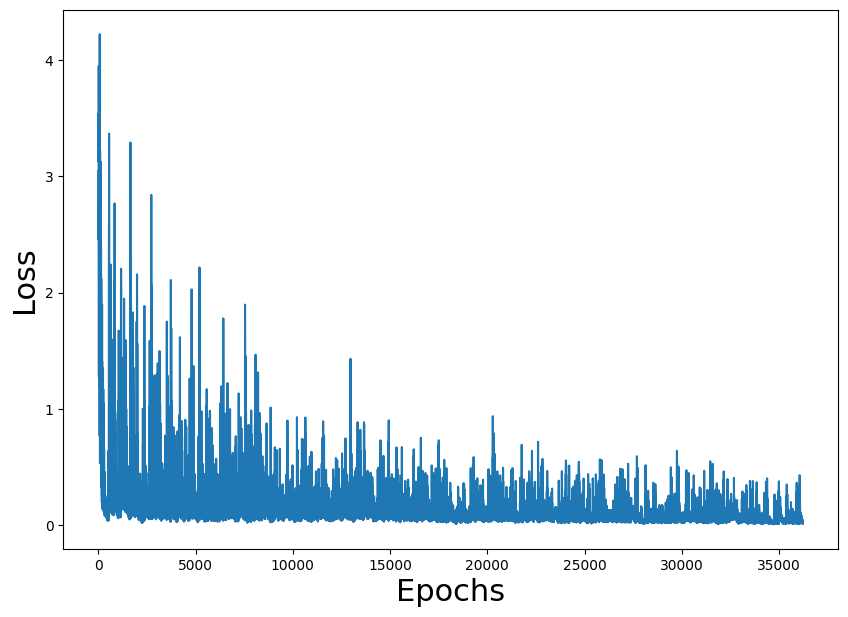

In [14]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

Q Table 

In [16]:
import pandas as pd
column_names = ["Epochs","Current_State", "Pit_Position", "Goal_Position", "Wall_Position", "Action", "Q_value"]
qt = pd.DataFrame(q_table, columns = column_names)
qt = qt.loc[(qt != 0).any(axis=1)]
qt

,Epochs,Current_State,Pit_Position,Goal_Position,Wall_Position,Action,Q_value
0,0,"(3, 2)","(0, 0)","(2, 1)","(1, 3)",0,0.047124
1,0,"(3, 2)","(0, 0)","(2, 1)","(1, 3)",1,0.056268
2,0,"(3, 2)","(0, 0)","(2, 1)","(1, 3)",2,-0.073546
3,0,"(3, 2)","(0, 0)","(2, 1)","(1, 3)",3,-0.098034
4,0,"(3, 2)","(0, 0)","(2, 1)","(1, 3)",0,0.047661
...,...,...,...,...,...,...,...
145699,4999,"(2, 2)","(1, 2)","(3, 1)","(0, 0)",3,5.452736
145700,4999,"(2, 1)","(1, 2)","(3, 1)","(0, 0)",0,6.114357
145701,4999,"(2, 1)","(1, 2)","(3, 1)","(0, 0)",1,10.232368
145702,4999,"(2, 1)","(1, 2)","(3, 1)","(0, 0)",2,6.290653


In [31]:
qt.describe()

,Epochs,Action,Q_value
count,145704.000000,145704.000000,145704.000000
mean,1926.902295,1.500000,2.297698
std,1515.201133,1.118038,4.703287
min,0.000000,0.000000,-25.326225
25%,499.000000,0.750000,-0.256461
50%,1632.000000,1.500000,3.188954
75%,3208.000000,2.250000,5.671231
max,4999.000000,3.000000,13.945859


Dataset

In [27]:
import pandas as pd
column_names = ["Epochs","Current_State", "Pit_Position", "Goal_Position", "Wall_Position", "Action",  "Reward", "Next_State", "Epsilon_Boolean", 
                "Q_Max", "Q1_Current", "Q2_Current", "Q3_Current", "Q4_Current", "Q1_Next", "Q2_Next", "Q3_Next", "Q4_Next"
                ]
df = pd.DataFrame(matrix, columns = column_names)
df = df.loc[(df != 0).any(axis=1)]
df

,Epochs,Current_State,Pit_Position,Goal_Position,Wall_Position,Action,Reward,Next_State,Epsilon_Boolean,Q_Max,Q1_Current,Q2_Current,Q3_Current,Q4_Current,Q1_Next,Q2_Next,Q3_Next,Q4_Next
0,0,"(3, 2)","(0, 0)","(2, 1)","(1, 3)",1,-1,"(3, 2)",0,0.056268,0.047124,0.056268,-0.073546,-0.098034,0.047661,0.056512,-0.073927,-0.098420
1,0,"(3, 2)","(0, 0)","(2, 1)","(1, 3)",1,-1,"(3, 2)",0,0.056512,0.047661,0.056512,-0.073927,-0.098420,0.046758,0.056617,-0.073951,-0.098522
2,0,"(3, 2)","(0, 0)","(2, 1)","(1, 3)",1,-1,"(3, 2)",0,0.056617,0.046758,0.056617,-0.073951,-0.098522,0.047393,0.057129,-0.073508,-0.098703
3,0,"(3, 2)","(0, 0)","(2, 1)","(1, 3)",1,-1,"(3, 2)",0,0.057129,0.047393,0.057129,-0.073508,-0.098703,0.047316,0.056891,-0.073931,-0.098439
4,0,"(3, 2)","(0, 0)","(2, 1)","(1, 3)",1,-1,"(3, 2)",0,0.056891,0.047316,0.056891,-0.073931,-0.098439,0.047312,0.057020,-0.073807,-0.098533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36421,4998,"(2, 1)","(3, 3)","(1, 0)","(2, 0)",0,-1,"(1, 1)",0,6.347949,6.347949,3.285752,6.137409,3.796087,5.288188,4.197951,9.756136,5.027224
36422,4998,"(1, 1)","(3, 3)","(1, 0)","(2, 0)",2,10,"(1, 0)",0,9.828738,5.330980,4.177354,9.828738,5.038331,5.345709,4.977504,6.517791,6.751531
36423,4999,"(2, 3)","(1, 2)","(3, 1)","(0, 0)",2,-1,"(2, 2)",0,5.842443,2.596179,4.518089,5.842443,1.683321,2.882107,7.055447,7.681408,5.437268
36424,4999,"(2, 2)","(1, 2)","(3, 1)","(0, 0)",2,-1,"(2, 1)",0,7.724342,2.909247,7.095088,7.724342,5.452736,6.080197,10.184771,6.277992,7.055487


In [28]:
df['Current_State'] = df['Current_State'].replace(['(0, 0)'],0)
df['Current_State'] = df['Current_State'].replace(['(0, 1)'],1)
df['Current_State'] = df['Current_State'].replace(['(0, 2)'],2)
df['Current_State'] = df['Current_State'].replace(['(0, 3)'],3)
df['Current_State'] = df['Current_State'].replace(['(1, 0)'],4)
df['Current_State'] = df['Current_State'].replace(['(1, 1)'],5)
df['Current_State'] = df['Current_State'].replace(['(1, 2)'],6)
df['Current_State'] = df['Current_State'].replace(['(1, 3)'],7)
df['Current_State'] = df['Current_State'].replace(['(2, 0)'],8)
df['Current_State'] = df['Current_State'].replace(['(2, 1)'],9)
df['Current_State'] = df['Current_State'].replace(['(2, 2)'],10)
df['Current_State'] = df['Current_State'].replace(['(2, 3)'],11)
df['Current_State'] = df['Current_State'].replace(['(3, 0)'],12)
df['Current_State'] = df['Current_State'].replace(['(3, 1)'],13)
df['Current_State'] = df['Current_State'].replace(['(3, 2)'],14)
df['Current_State'] = df['Current_State'].replace(['(3, 3)'],15)

df['Next_State'] = df['Next_State'].replace(['(0, 0)'],0)
df['Next_State'] = df['Next_State'].replace(['(0, 1)'],1)
df['Next_State'] = df['Next_State'].replace(['(0, 2)'],2)
df['Next_State'] = df['Next_State'].replace(['(0, 3)'],3)
df['Next_State'] = df['Next_State'].replace(['(1, 0)'],4)
df['Next_State'] = df['Next_State'].replace(['(1, 1)'],5)
df['Next_State'] = df['Next_State'].replace(['(1, 2)'],6)
df['Next_State'] = df['Next_State'].replace(['(1, 3)'],7)
df['Next_State'] = df['Next_State'].replace(['(2, 0)'],8)
df['Next_State'] = df['Next_State'].replace(['(2, 1)'],9)
df['Next_State'] = df['Next_State'].replace(['(2, 2)'],10)
df['Next_State'] = df['Next_State'].replace(['(2, 3)'],11)
df['Next_State'] = df['Next_State'].replace(['(3, 0)'],12)
df['Next_State'] = df['Next_State'].replace(['(3, 1)'],13)
df['Next_State'] = df['Next_State'].replace(['(3, 2)'],14)
df['Next_State'] = df['Next_State'].replace(['(3, 3)'],15)

df['Goal_Position'] = df['Goal_Position'].replace(['(0, 0)'],0)
df['Goal_Position'] = df['Goal_Position'].replace(['(0, 1)'],1)
df['Goal_Position'] = df['Goal_Position'].replace(['(0, 2)'],2)
df['Goal_Position'] = df['Goal_Position'].replace(['(0, 3)'],3)
df['Goal_Position'] = df['Goal_Position'].replace(['(1, 0)'],4)
df['Goal_Position'] = df['Goal_Position'].replace(['(1, 1)'],5)
df['Goal_Position'] = df['Goal_Position'].replace(['(1, 2)'],6)
df['Goal_Position'] = df['Goal_Position'].replace(['(1, 3)'],7)
df['Goal_Position'] = df['Goal_Position'].replace(['(2, 0)'],8)
df['Goal_Position'] = df['Goal_Position'].replace(['(2, 1)'],9)
df['Goal_Position'] = df['Goal_Position'].replace(['(2, 2)'],10)
df['Goal_Position'] = df['Goal_Position'].replace(['(2, 3)'],11)
df['Goal_Position'] = df['Goal_Position'].replace(['(3, 0)'],12)
df['Goal_Position'] = df['Goal_Position'].replace(['(3, 1)'],13)
df['Goal_Position'] = df['Goal_Position'].replace(['(3, 2)'],14)
df['Goal_Position'] = df['Goal_Position'].replace(['(3, 3)'],15)

df['Pit_Position'] = df['Pit_Position'].replace(['(0, 0)'],0)
df['Pit_Position'] = df['Pit_Position'].replace(['(0, 1)'],1)
df['Pit_Position'] = df['Pit_Position'].replace(['(0, 2)'],2)
df['Pit_Position'] = df['Pit_Position'].replace(['(0, 3)'],3)
df['Pit_Position'] = df['Pit_Position'].replace(['(1, 0)'],4)
df['Pit_Position'] = df['Pit_Position'].replace(['(1, 1)'],5)
df['Pit_Position'] = df['Pit_Position'].replace(['(1, 2)'],6)
df['Pit_Position'] = df['Pit_Position'].replace(['(1, 3)'],7)
df['Pit_Position'] = df['Pit_Position'].replace(['(2, 0)'],8)
df['Pit_Position'] = df['Pit_Position'].replace(['(2, 1)'],9)
df['Pit_Position'] = df['Pit_Position'].replace(['(2, 2)'],10)
df['Pit_Position'] = df['Pit_Position'].replace(['(2, 3)'],11)
df['Pit_Position'] = df['Pit_Position'].replace(['(3, 0)'],12)
df['Pit_Position'] = df['Pit_Position'].replace(['(3, 1)'],13)
df['Pit_Position'] = df['Pit_Position'].replace(['(3, 2)'],14)
df['Pit_Position'] = df['Pit_Position'].replace(['(3, 3)'],15)

df['Wall_Position'] = df['Wall_Position'].replace(['(1, 1)'],5)
df['Wall_Position'] = df['Wall_Position'].replace(['(0, 0)'],0)
df['Wall_Position'] = df['Wall_Position'].replace(['(0, 1)'],1)
df['Wall_Position'] = df['Wall_Position'].replace(['(0, 2)'],2)
df['Wall_Position'] = df['Wall_Position'].replace(['(0, 3)'],3)
df['Wall_Position'] = df['Wall_Position'].replace(['(1, 0)'],4)
df['Wall_Position'] = df['Wall_Position'].replace(['(1, 1)'],5)
df['Wall_Position'] = df['Wall_Position'].replace(['(1, 2)'],6)
df['Wall_Position'] = df['Wall_Position'].replace(['(1, 3)'],7)
df['Wall_Position'] = df['Wall_Position'].replace(['(2, 0)'],8)
df['Wall_Position'] = df['Wall_Position'].replace(['(2, 1)'],9)
df['Wall_Position'] = df['Wall_Position'].replace(['(2, 2)'],10)
df['Wall_Position'] = df['Wall_Position'].replace(['(2, 3)'],11)
df['Wall_Position'] = df['Wall_Position'].replace(['(3, 0)'],12)
df['Wall_Position'] = df['Wall_Position'].replace(['(3, 1)'],13)
df['Wall_Position'] = df['Wall_Position'].replace(['(3, 2)'],14)
df['Wall_Position'] = df['Wall_Position'].replace(['(3, 3)'],15)

In [29]:
df

,Epochs,Current_State,Pit_Position,Goal_Position,Wall_Position,Action,Reward,Next_State,Epsilon_Boolean,Q_Max,Q1_Current,Q2_Current,Q3_Current,Q4_Current,Q1_Next,Q2_Next,Q3_Next,Q4_Next
0,0,14,0,9,7,1,-1,14,0,0.056268,0.047124,0.056268,-0.073546,-0.098034,0.047661,0.056512,-0.073927,-0.098420
1,0,14,0,9,7,1,-1,14,0,0.056512,0.047661,0.056512,-0.073927,-0.098420,0.046758,0.056617,-0.073951,-0.098522
2,0,14,0,9,7,1,-1,14,0,0.056617,0.046758,0.056617,-0.073951,-0.098522,0.047393,0.057129,-0.073508,-0.098703
3,0,14,0,9,7,1,-1,14,0,0.057129,0.047393,0.057129,-0.073508,-0.098703,0.047316,0.056891,-0.073931,-0.098439
4,0,14,0,9,7,1,-1,14,0,0.056891,0.047316,0.056891,-0.073931,-0.098439,0.047312,0.057020,-0.073807,-0.098533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36421,4998,9,15,4,8,0,-1,5,0,6.347949,6.347949,3.285752,6.137409,3.796087,5.288188,4.197951,9.756136,5.027224
36422,4998,5,15,4,8,2,10,4,0,9.828738,5.330980,4.177354,9.828738,5.038331,5.345709,4.977504,6.517791,6.751531
36423,4999,11,6,13,0,2,-1,10,0,5.842443,2.596179,4.518089,5.842443,1.683321,2.882107,7.055447,7.681408,5.437268
36424,4999,10,6,13,0,2,-1,9,0,7.724342,2.909247,7.095088,7.724342,5.452736,6.080197,10.184771,6.277992,7.055487


In [30]:
df.describe()

,Epochs,Current_State,Pit_Position,Goal_Position,Wall_Position,Action,Reward,Next_State,Epsilon_Boolean,Q_Max,Q1_Current,Q2_Current,Q3_Current,Q4_Current,Q1_Next,Q2_Next,Q3_Next,Q4_Next
count,36426.000000,36426.000000,36426.000000,36426.000000,36426.000000,36426.000000,36426.000000,36426.000000,36426.000000,36426.000000,36426.000000,36426.000000,36426.000000,36426.000000,36426.000000,36426.000000,36426.000000,36426.000000
mean,1926.902295,7.641520,7.394498,7.721847,7.638802,1.532971,0.176605,7.630841,0.301186,3.873735,2.300164,2.229268,2.268062,2.393295,2.534825,2.461089,2.510843,2.634765
std,1515.216732,4.581066,4.572062,4.716168,4.426813,1.121364,3.775807,4.576413,0.458780,4.783746,4.725364,4.768179,4.714573,4.602061,4.810149,4.851486,4.802009,4.688410
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-10.000000,0.000000,0.000000,-14.224359,-19.936337,-20.145048,-25.326225,-17.304129,-19.986580,-20.122274,-24.112274,-17.257971
25%,499.000000,4.000000,3.000000,3.000000,4.000000,1.000000,-1.000000,4.000000,0.000000,1.041072,-0.248848,-0.314161,-0.302679,-0.144683,-0.111111,-0.186398,-0.152664,-0.088528
50%,1632.000000,8.000000,7.000000,8.000000,8.000000,2.000000,-1.000000,8.000000,0.000000,4.810662,3.212109,3.097237,3.179951,3.258228,3.515651,3.444242,3.507398,3.574448
75%,3208.000000,12.000000,11.000000,12.000000,11.000000,3.000000,-1.000000,11.000000,1.000000,7.501451,5.691128,5.627475,5.666094,5.699657,6.075595,6.012802,6.072417,6.111328
max,4999.000000,15.000000,15.000000,15.000000,15.000000,3.000000,10.000000,15.000000,1.000000,13.945859,13.945859,13.740882,13.592063,13.329181,13.988853,13.763917,16.256046,13.294545


Random Epoch Representation

In [34]:
df[df['Epochs'] == 3856]

,Epochs,Current_State,Pit_Position,Goal_Position,Wall_Position,Action,Reward,Next_State,Epsilon_Boolean,Q_Max,Q1_Current,Q2_Current,Q3_Current,Q4_Current,Q1_Next,Q2_Next,Q3_Next,Q4_Next
30840,3856,13,0,7,1,3,-1,14,0,4.636250,4.368138,3.576052,3.626929,4.636250,6.388455,4.990588,3.803637,5.767718
30841,3856,14,0,7,1,2,-1,13,1,6.390426,6.390426,5.010311,3.776885,5.745503,4.331831,3.560120,3.551113,4.598433
30842,3856,13,0,7,1,3,-1,14,0,4.599113,4.335627,3.584592,3.533705,4.599113,6.435544,5.088209,3.808327,5.783142
30843,3856,14,0,7,1,0,-1,10,0,6.428998,6.428998,5.117799,3.783308,5.768186,7.764074,6.049346,4.839417,7.575496
30844,3856,10,0,7,1,0,-1,6,0,7.764817,7.764817,6.074650,4.832722,7.574137,7.341522,6.694673,6.537148,9.090682
30845,3856,6,0,7,1,3,10,7,0,9.079890,7.337638,6.727499,6.546893,9.079890,9.134897,9.118249,6.671686,8.533966
